In [1]:
import json
import pandas as pd
import numpy as np
# !pip3 install nltk
import nltk
# nltk.download('word2vec_sample')
# !pip3 install gensim 
import gensim
# !pip3 install -U scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
import sys
sys.path.append('../src/')
from data.preprocess_keywords import make_cleaned_keywords_df
from data.make_datasets import get_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE
import collections




In [86]:
## ONLY REERUN IF YOU WANA PREEEPROCESS AGAIN 
# #let's load and clean data
# # Specify wanted time range
# data_dir = '/home/marios/data/dw-project-data/CMS_2010_to_June_2022_ENGLISH.json'
# start_date = '2019-01-01'
# end_date = '2022-01-01'
# # Load and extract data within time range
# df_subset = get_data(data_dir, start_date, end_date)
# # Cleans keywords and saves data as a dataframe
# make_cleaned_keywords_df(df_subset, start_date, end_date)

Getting data...
Loading data DONE. Number of articles is 175659
Extracting data DONE. Number of articles from 2019-01-01 to 2022-01-01 is 33829
Cleaning step 1 out of 2 DONE. Number of unique keywords went from 32682 to 30228
Cleaning step 2 out of 2 DONE. Number of unique keywords went from 30228 to 27992
Finished. Data stored in ../data/interim/clean_keywords_2019-01-01_2022-01-01.json


In [5]:
clean_df_path = '/home/marios/S2DS/Spring23_DW/data/interim/clean_keywords_2019-01-01_2022-01-01.json'
df = pd.read_json(clean_df_path, orient ='split', compression = 'infer')
df_clean = df.copy()
df_clean = df_clean.dropna()
df_clean.info()
df_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33540 entries, 0 to 33828
Data columns (total 5 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            33540 non-null  int64 
 1   lastModifiedDate              33540 non-null  object
 2   keywordStrings                33540 non-null  object
 3   keywordStringsCleanAfterFuzz  33540 non-null  object
 4   cleanFocusCategory            33540 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.5+ MB


id          lastModifiedDate  \
0  46912921  2019-01-01T03:57:28.904Z   
1  46911356  2019-01-01T06:11:50.527Z   
2  46909694  2019-01-01T06:14:35.563Z   
3  46912694  2019-01-01T08:26:11.599Z   
4  46910092  2019-01-01T09:05:00.736Z   

                                      keywordStrings  \
0                [NASA, OSIRIS-REx, Bennu, asteroid]   
1  [English Channel, migration, boats, illegal im...   
2  [Brazil, Jair Bolsonaro, Chicago economics, Ha...   
3                   [Japan, Tokyo, Harajuku, attack]   
4  [Asia, Bangladesh, elections, Kamal Hossain, S...   

                        keywordStringsCleanAfterFuzz cleanFocusCategory  
0                [nasa, osiris-rex, bennu, asteroid]            Science  
1  [english channel, migration, boats, illegal im...    Law and Justice  
2  [brazil, jair bolsonaro, chicago economics, ha...           Politics  
3                   [japan, tokyo, harajuku, attack]    Law and Justice  
4  [asia, bangladesh, elections, kamal hossain, s...           Politics

In [6]:
# let's load a pre-trained word2vec model from google
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/home/marios/local_data_s2ds/GoogleNews-vectors-negative300.bin',
                                                               binary=True,)

In [7]:
corpus = [l for l in df_clean['keywordStringsCleanAfterFuzz'].apply(lambda x: ', '.join(x))]

In [8]:
# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')
# Converting the text to numeric data
X = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())
# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['cleanFocusCategory']=df_clean['cleanFocusCategory'].values

print(CountVectorizedData.shape)
CountVectorizedData.head()
WordsVocab=CountVectorizedData.columns[:-1]
print(WordsVocab.shape)


(33540, 20759)
(20758,)


/home/marios/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [9]:
def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):
        # initiating a vector for embeddings
        Sentence = np.zeros(300)
        # Looping thru each word in the sentence and if it's present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            print(word)
            if word in GoogleModel.key_to_index.keys():    
                Sentence=Sentence+GoogleModel[word]
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [183]:
## ONLY RERUN IF YOU WANNA OVERWRITE- 16 MINS
#W2Vec_Data=FunctionText2Vec(corpus)

asteroid
bennu
nasa
osiris
rex
boats
channel
english
illegal
immigration
migration
bolsonaro
brazil
chicago
economics
guedes
hamilton
jair
mourao
paulo
attack
harajuku
japan
tokyo
asia
awami
bangladesh
elections
hasina
hossain
kamal
khaleda
league
sheikh
zia
ayatollah
civil
deal
hassan
iran
jcpoa
khomeini
nuclear
rouhani
sanctions
society
tehran
bucharest
dancila
dragnea
eu
iohannis
klaus
liviu
romania
viorica
adulterated
alcohol
booze
counterfeit
fake
food
fraud
böll
der
edgar
friseur
heinrich
hilsenrath
jude
nazi
schriftsteller
disasters
indonesia
java
landslide
natural
hawaii
ironman
lange
patrick
countdown
new
solutions
year
germany
münster
arab
east
gulf
iran
league
middle
states
syria
asia
awami
bangladesh
bnp
elections
hasina
khaleda
league
sheikh
zia
cup
federer
hopman
roger
serena
williams
africa
congo
democratic
dr
election
elections
observers
republic
brandt
gnabry
joachim
julian
leroy
löw
sane
serge
eisenbichler
garmisch
hills
kamil
kobayashi
markus
partenkirchen
ryoyu
stoc

In [184]:
np.save('/home/marios/local_data_s2ds/w2v_data_2019_2022_clean.npy', W2Vec_Data)

In [3]:
W2Vec_Data = np.load('/home/marios/local_data_s2ds/w2v_data_2019_2022_clean.npy')
W2Vec_Data = pd.DataFrame(W2Vec_Data)
W2Vec_Data

0         1         2         3         4         5         6    \
0     -0.182617  0.047119  0.154297  0.467773 -0.137695 -0.589355  0.196259   
1     -0.154053  0.113770  0.041992 -0.263184 -0.719360 -0.577271 -0.123596   
2     -0.426941  0.242188  0.209290  1.017578  0.179688  0.282715 -0.306396   
3     -0.198242  0.104614  0.247375  0.513184 -0.313599 -0.008881 -0.332520   
4     -0.441406  0.484619 -0.508911  0.346375  0.102509 -0.066147 -0.517212   
...         ...       ...       ...       ...       ...       ...       ...   
33535 -0.611969  0.297241  0.172134  0.664062 -0.553101 -0.136230  0.018799   
33536 -0.100769  0.077759  0.301529  0.252441 -0.767822 -0.338562 -0.164551   
33537  0.917236 -0.583008 -0.089355  1.059814  0.315186 -0.833984 -0.261459   
33538 -0.982178 -0.184357 -0.305405  0.883644  0.086060 -0.363525 -0.119019   
33539  0.391846  0.514160 -0.547852  0.697998 -0.244667 -0.460083  0.465179   

            7         8         9    ...       290       291       292  \
0     -0.612854  0.220215 -0.068726  ...  0.154785  0.447266 -0.489746   
1      0.309570  0.201172  0.320068  ...  0.016357  0.215561  0.845909   
2     -0.980957 -0.179443  0.467773  ... -0.016602  0.634399  0.228271   
3     -0.748047  0.749023  0.258789  ...  0.247070  0.119141  0.511719   
4     -0.897079  0.038574  1.435547  ... -0.125290  0.001953  0.365234   
...         ...       ...       ...  ...       ...       ...       ...   
33535 -0.360718  0.540771  0.995117  ...  0.248047  0.569336 -0.296631   
33536 -0.715820  0.204346  0.502930  ... -0.149170  0.447754 -0.410156   
33537 -0.742676 -0.137207  0.194599  ...  0.333618  0.000824 -0.850410   
33538 -1.484253  0.030029  0.752625  ... -0.923523 -0.143188  0.795410   
33539 -1.036560  0.449951 -0.731270  ... -0.366821  0.844971 -0.530884   

            293       294       295       296       297       298       299  
0      0.336731  0.023804 -0.051758 -0.420166 -0.286865  0.342285  0.759033  
1      0.062622  0.300781  0.254883  0.032059 -0.284668  0.453857  0.143555  
2      0.607666 -0.173828 -0.103760 -0.198181 -1.099854 -0.002441  0.262787  
3      0.600586 -0.153992 -0.337891 -1.121094 -0.094604 -0.327637  0.588867  
4     -0.241821 -0.333252  0.687500 -0.953613 -0.234451 -0.553955  1.435547  
...         ...       ...       ...       ...       ...       ...       ...  
33535  0.351685  0.282532  0.192627  0.247437  0.446045  0.889832  0.021484  
33536  0.343506 -0.090271 -0.045410 -0.424561  0.017578 -0.277832 -0.493896  
33537  0.248871  1.259033  0.003662 -1.717041  0.221191 -0.575317 -0.305664  
33538  0.760620  0.516418  0.134521 -0.070923  0.777161  1.153172 -0.079834  
33539 -0.276611 -0.938721  0.971924 -0.546631  0.123535  0.595215  1.203125  

[33540 rows x 300 columns]

In [37]:

# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['cleanFocusCategory']=df['cleanFocusCategory']
 
# Assigning to DataForML variable
DataForML=W2Vec_Data
DataForML

0         1         2         3         4         5         6  \
0     -0.182617  0.047119  0.154297  0.467773 -0.137695 -0.589355  0.196259   
1     -0.154053  0.113770  0.041992 -0.263184 -0.719360 -0.577271 -0.123596   
2     -0.426941  0.242188  0.209290  1.017578  0.179688  0.282715 -0.306396   
3     -0.198242  0.104614  0.247375  0.513184 -0.313599 -0.008881 -0.332520   
4     -0.441406  0.484619 -0.508911  0.346375  0.102509 -0.066147 -0.517212   
...         ...       ...       ...       ...       ...       ...       ...   
33535 -0.611969  0.297241  0.172134  0.664062 -0.553101 -0.136230  0.018799   
33536 -0.100769  0.077759  0.301529  0.252441 -0.767822 -0.338562 -0.164551   
33537  0.917236 -0.583008 -0.089355  1.059814  0.315186 -0.833984 -0.261459   
33538 -0.982178 -0.184357 -0.305405  0.883644  0.086060 -0.363525 -0.119019   
33539  0.391846  0.514160 -0.547852  0.697998 -0.244667 -0.460083  0.465179   

              7         8         9  ...       291       292       293  \
0     -0.612854  0.220215 -0.068726  ...  0.447266 -0.489746  0.336731   
1      0.309570  0.201172  0.320068  ...  0.215561  0.845909  0.062622   
2     -0.980957 -0.179443  0.467773  ...  0.634399  0.228271  0.607666   
3     -0.748047  0.749023  0.258789  ...  0.119141  0.511719  0.600586   
4     -0.897079  0.038574  1.435547  ...  0.001953  0.365234 -0.241821   
...         ...       ...       ...  ...       ...       ...       ...   
33535 -0.360718  0.540771  0.995117  ...  0.569336 -0.296631  0.351685   
33536 -0.715820  0.204346  0.502930  ...  0.447754 -0.410156  0.343506   
33537 -0.742676 -0.137207  0.194599  ...  0.000824 -0.850410  0.248871   
33538 -1.484253  0.030029  0.752625  ... -0.143188  0.795410  0.760620   
33539 -1.036560  0.449951 -0.731270  ...  0.844971 -0.530884 -0.276611   

            294       295       296       297       298       299  \
0      0.023804 -0.051758 -0.420166 -0.286865  0.342285  0.759033   
1      0.300781  0.254883  0.032059 -0.284668  0.453857  0.143555   
2     -0.173828 -0.103760 -0.198181 -1.099854 -0.002441  0.262787   
3     -0.153992 -0.337891 -1.121094 -0.094604 -0.327637  0.588867   
4     -0.333252  0.687500 -0.953613 -0.234451 -0.553955  1.435547   
...         ...       ...       ...       ...       ...       ...   
33535  0.282532  0.192627  0.247437  0.446045  0.889832  0.021484   
33536 -0.090271 -0.045410 -0.424561  0.017578 -0.277832 -0.493896   
33537  1.259033  0.003662 -1.717041  0.221191 -0.575317 -0.305664   
33538  0.516418  0.134521 -0.070923  0.777161  1.153172 -0.079834   
33539 -0.938721  0.971924 -0.546631  0.123535  0.595215  1.203125   

       cleanFocusCategory  
0                 Science  
1         Law and Justice  
2                Politics  
3         Law and Justice  
4                Politics  
...                   ...  
33535            Business  
33536              Health  
33537            Politics  
33538     Law and Justice  
33539             History  

[33540 rows x 301 columns]

In [36]:

#drop categories which are rare
elements_count = collections.Counter(DataForML.cleanFocusCategory)
data_slim = DataForML.copy()
# printing the element and the frequency
for key, value in elements_count.items():
   if value <100:
    print(f"{key}: {value}")
    data_slim = data_slim[data_slim.cleanFocusCategory != key ]

data_slim

Lifestyle: 79
Digital World: 46
Learning German: 25
Offbeat: 31
Innovation: 3


0         1         2         3         4         5         6  \
0     -0.182617  0.047119  0.154297  0.467773 -0.137695 -0.589355  0.196259   
1     -0.154053  0.113770  0.041992 -0.263184 -0.719360 -0.577271 -0.123596   
2     -0.426941  0.242188  0.209290  1.017578  0.179688  0.282715 -0.306396   
3     -0.198242  0.104614  0.247375  0.513184 -0.313599 -0.008881 -0.332520   
4     -0.441406  0.484619 -0.508911  0.346375  0.102509 -0.066147 -0.517212   
...         ...       ...       ...       ...       ...       ...       ...   
33535 -0.611969  0.297241  0.172134  0.664062 -0.553101 -0.136230  0.018799   
33536 -0.100769  0.077759  0.301529  0.252441 -0.767822 -0.338562 -0.164551   
33537  0.917236 -0.583008 -0.089355  1.059814  0.315186 -0.833984 -0.261459   
33538 -0.982178 -0.184357 -0.305405  0.883644  0.086060 -0.363525 -0.119019   
33539  0.391846  0.514160 -0.547852  0.697998 -0.244667 -0.460083  0.465179   

              7         8         9  ...       291       292       293  \
0     -0.612854  0.220215 -0.068726  ...  0.447266 -0.489746  0.336731   
1      0.309570  0.201172  0.320068  ...  0.215561  0.845909  0.062622   
2     -0.980957 -0.179443  0.467773  ...  0.634399  0.228271  0.607666   
3     -0.748047  0.749023  0.258789  ...  0.119141  0.511719  0.600586   
4     -0.897079  0.038574  1.435547  ...  0.001953  0.365234 -0.241821   
...         ...       ...       ...  ...       ...       ...       ...   
33535 -0.360718  0.540771  0.995117  ...  0.569336 -0.296631  0.351685   
33536 -0.715820  0.204346  0.502930  ...  0.447754 -0.410156  0.343506   
33537 -0.742676 -0.137207  0.194599  ...  0.000824 -0.850410  0.248871   
33538 -1.484253  0.030029  0.752625  ... -0.143188  0.795410  0.760620   
33539 -1.036560  0.449951 -0.731270  ...  0.844971 -0.530884 -0.276611   

            294       295       296       297       298       299  \
0      0.023804 -0.051758 -0.420166 -0.286865  0.342285  0.759033   
1      0.300781  0.254883  0.032059 -0.284668  0.453857  0.143555   
2     -0.173828 -0.103760 -0.198181 -1.099854 -0.002441  0.262787   
3     -0.153992 -0.337891 -1.121094 -0.094604 -0.327637  0.588867   
4     -0.333252  0.687500 -0.953613 -0.234451 -0.553955  1.435547   
...         ...       ...       ...       ...       ...       ...   
33535  0.282532  0.192627  0.247437  0.446045  0.889832  0.021484   
33536 -0.090271 -0.045410 -0.424561  0.017578 -0.277832 -0.493896   
33537  1.259033  0.003662 -1.717041  0.221191 -0.575317 -0.305664   
33538  0.516418  0.134521 -0.070923  0.777161  1.153172 -0.079834   
33539 -0.938721  0.971924 -0.546631  0.123535  0.595215  1.203125   

       cleanFocusCategory  
0                 Science  
1         Law and Justice  
2                Politics  
3         Law and Justice  
4                Politics  
...                   ...  
33535            Business  
33536              Health  
33537            Politics  
33538     Law and Justice  
33539             History  

[33356 rows x 301 columns]

In [46]:
# let's changee names to numbers 
primary_categories = ['Education', 'Law and Justice', 'Politics', 'Religion', 
                        'Society', 'Nature and Environment', 
                        'Health', 'Catastrophe',  'None', 'Media', 'Sports', 'Culture', 'Science',
                        'Business', 'History', 'Travel', 'Human Rights', 'Technology', 'Migration', 
                        'Cars and Transportation']
primary_categories = sorted(primary_categories)
prim_cat_dict = {}
for i, cat in enumerate(primary_categories):
    prim_cat_dict[cat] = i+1

data_slim['cleanFocusCategory'] = data_slim['cleanFocusCategory'].apply(lambda x: prim_cat_dict[x] if x in prim_cat_dict else x)


In [48]:
elements_count = collections.Counter(data_slim.cleanFocusCategory)

for key, value in elements_count.items():
    print(f"{key}: {value}")

#SOMETHING WRONG?? CHECK


16.0: 686
9.0: 2631
14.0: 12169
1.0: 2301
4.0: 2321
3.0: 782
18.0: 2602
17.0: 2420
6.0: 2012
12.0: 1809
2.0: 177
8.0: 711
nan: 1
19.0: 281
20.0: 328
15.0: 277
10.0: 919
5.0: 139
7.0: 334
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
nan: 1
n

In [38]:

# Separate Target Variable and Predictor Variables
TargetVariable=data_slim.columns[-1]
Predictors=data_slim.columns[:-1]
 
X=data_slim[Predictors].values
y=data_slim[TargetVariable].values
 


In [12]:
#let's scale
PredictorScaler=MinMaxScaler()
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
# Generating the standardized values of X
X=PredictorScalerFit.transform(X)

In [13]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(23478, 300)
(23478,)
(10062, 300)
(10062,)


In [17]:
#let's balance classes
smote_sampler = SMOTE(random_state = 5)
X_smo, y_smo = smote_sampler.fit_resample(X_train, y_train)

elements_count = collections.Counter(y_train)
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

Education: 100
Law and Justice: 1854
Politics: 8496
Religion: 195
Society: 1707
Nature and Environment: 1291
Health: 1400
Catastrophe: 544
None: 195
Media: 616
Sports: 1821
Culture: 1656
Science: 462
Business: 1591
History: 230
Lifestyle: 52
Travel: 229
Human Rights: 504
Technology: 205
Migration: 123
Cars and Transportation: 132
Digital World: 32
Learning German: 22
Offbeat: 19
Innovation: 2


TypeError: '<' not supported between instances of 'NoneType' and 'str'

In [26]:
y_train

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

(23478, 300)
(23478,)
(10062, 300)
(10062,)


In [44]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
 
# GaussianNB is used in Binomial Classification
# MultinomialNB is used in multi-class classification
#clf = GaussianNB()
clf = MultinomialNB()
 
# Printing all the parameters of Naive Bayes
print(clf)
 
NB=clf.fit(X_train,y_train)
prediction=NB.predict(X_test)
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
 
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score
 
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
Accuracy_Values=cross_val_score(NB, X , y, cv=5, scoring='f1_weighted')
print('\nAccuracy values for 5-fold Cross Validation:\n',Accuracy_Values)
print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

MultinomialNB()


/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

           Architecture       0.00      0.00      0.00        10
                   Arts       0.00      0.00      0.00       107
               Business       1.00      0.00      0.01      2020
Cars and Transportation       0.00      0.00      0.00       132
            Catastrophe       0.00      0.00      0.00       599
                Climate       0.00      0.00      0.00        21
              Conflicts       0.00      0.00      0.00      1487
             Corruption       0.00      0.00      0.00         2
                  Crime       0.00      0.00      0.00      1196
                Culture       0.00      0.00      0.00      1858
                  Dance       0.00      0.00      0.00         5
                 Design       0.00      0.00      0.00         4
          Digital World       0.00      0.00      0.00        42
              Diversity       0.00      0.00      0.00         3
              Education 

In [45]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=46)
 
# Printing all the parameters of KNN
print(clf)
 
# Creating the model on Training Data
KNN=clf.fit(X_train,y_train)
prediction=KNN.predict(X_test)
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
 
# Importing cross validation function from sklearn
from sklearn.model_selection import cross_val_score
 
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
#Accuracy_Values=cross_val_score(KNN, X , y, cv=10, scoring='f1_weighted')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))
 
# Plotting the feature importance for Top 10 most important columns
# There is no built-in method to get feature importance in KNN


KNeighborsClassifier(n_neighbors=46)


/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

           Architecture       0.00      0.00      0.00        10
                   Arts       0.00      0.00      0.00       107
               Business       0.75      0.52      0.62      2020
Cars and Transportation       0.50      0.09      0.15       132
            Catastrophe       0.54      0.39      0.45       599
                Climate       0.00      0.00      0.00        21
              Conflicts       0.45      0.50      0.47      1487
             Corruption       0.00      0.00      0.00         2
                  Crime       0.54      0.40      0.46      1196
                Culture       0.67      0.52      0.59      1858
                  Dance       0.00      0.00      0.00         5
                 Design       0.00      0.00      0.00         4
          Digital World       0.00      0.00      0.00        42
              Diversity       0.00      0.00      0.00         3
              Education 

In [46]:
from sklearn.linear_model import LogisticRegression
# choose parameter Penalty='l1' or C=1
# choose different values for solver 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
clf = LogisticRegression(C=10,penalty='l2', solver='newton-cg')
 
# Printing all the parameters of logistic regression
# print(clf)
 
# Creating the model on Training Data
LOG=clf.fit(X_train,y_train)
 
# Generating predictions on testing data
prediction=LOG.predict(X_test)
# Printing sample values of prediction in Testing data
TestingData=pd.DataFrame(data=X_test, columns=Predictors)
TestingData['Survived']=y_test
TestingData['Predicted_Survived']=prediction
print(TestingData.head())
 
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(prediction, y_test))
 
## Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
 
## Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score
 
## Running 10-Fold Cross validation on a given algorithm
## Passing full data X and y because the K-fold will split the data and automatically choose train/test
#Accuracy_Values=cross_val_score(LOG, X , y, cv=10, scoring='f1_weighted')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  ConvergenceWarning,


          0         1         2         3         4         5         6  \
0  0.461164  0.364236  0.540574  0.458724  0.521273  0.663672  0.346977   
1  0.317105  0.326145  0.563875  0.363254  0.750566  0.658474  0.520716   
2  0.421529  0.410348  0.477047  0.469305  0.605007  0.527551  0.384802   
3  0.301420  0.388042  0.558668  0.333140  0.717092  0.546199  0.572567   
4  0.581959  0.351630  0.290939  0.428102  0.725028  0.597278  0.231202   

          7         8         9  ...       292       293       294       295  \
0  0.499663  0.463192  0.555038  ...  0.735587  0.621939  0.467713  0.622281   
1  0.637010  0.461076  0.635882  ...  0.526223  0.456953  0.514804  0.561677   
2  0.690352  0.544605  0.602065  ...  0.708767  0.491091  0.760175  0.592852   
3  0.605582  0.482384  0.500066  ...  0.561804  0.385071  0.542578  0.554821   
4  0.405439  0.569468  0.558507  ...  0.555420  0.368912  0.747028  0.672402   

        296       297       298       299                Survived  \

/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

           Architecture       0.00      0.00      0.00        10
                   Arts       0.38      0.14      0.20       107
               Business       0.69      0.67      0.68      2020
Cars and Transportation       0.39      0.23      0.29       132
            Catastrophe       0.56      0.48      0.52       599
                Climate       0.00      0.00      0.00        21
              Conflicts       0.55      0.41      0.47      1487
             Corruption       0.00      0.00      0.00         2
                  Crime       0.54      0.47      0.50      1196
                Culture       0.62      0.66      0.64      1858
                  Dance       0.00      0.00      0.00         5
                 Design       1.00      0.50      0.67         4
          Digital World       0.20      0.05      0.08        42
              Diversity       0.00      0.00      0.00         3
              Education 

DecisionTreeClassifier(max_depth=20)


/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

           Architecture       0.00      0.00      0.00        10
                   Arts       0.04      0.06      0.04       107
               Business       0.38      0.40      0.39      2020
Cars and Transportation       0.04      0.03      0.03       132
            Catastrophe       0.21      0.18      0.19       599
                Climate       0.00      0.00      0.00        21
              Conflicts       0.30      0.33      0.31      1487
             Corruption       0.00      0.00      0.00         2
                  Crime       0.23      0.20      0.22      1196
                Culture       0.37      0.37      0.37      1858
                  Dance       0.00      0.00      0.00         5
                 Design       0.00      0.00      0.00         4
          Digital World       0.04      0.02      0.03        42
              Diversity       0.00      0.00      0.00         3
              Education 

<AxesSubplot:>

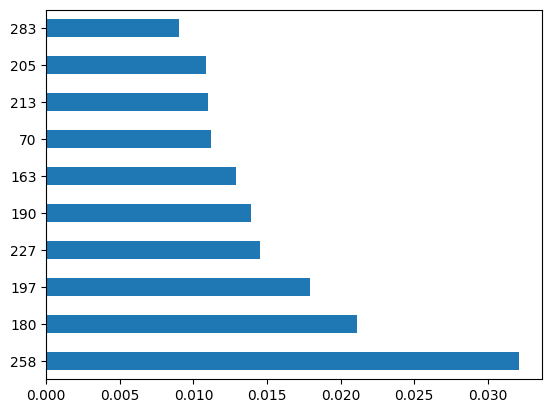

In [47]:
# Decision Trees
from sklearn import tree
#choose from different tunable hyper parameters
clf = tree.DecisionTreeClassifier(max_depth=20,criterion='gini')
 
# Printing all the parameters of Decision Trees
print(clf)
 
# Creating the model on Training Data
DTree=clf.fit(X_train,y_train)
prediction=DTree.predict(X_test)
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
 
# Plotting the feature importance for Top 10 most important columns
%matplotlib inline
feature_importances = pd.Series(DTree.feature_importances_, index=Predictors)
feature_importances.nlargest(10).plot(kind='barh')
 
# Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score
 
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
#Accuracy_Values=cross_val_score(DTree, X , y, cv=10, scoring='f1_weighted')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))

In [48]:
# Adaboost 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
 
# Choosing Decision Tree with 1 level as the weak learner
DTC=DecisionTreeClassifier(max_depth=2)
clf = AdaBoostClassifier(n_estimators=20, base_estimator=DTC ,learning_rate=0.01)
 
# Printing all the parameters of Adaboost
print(clf)
 
# Creating the model on Training Data
AB=clf.fit(X_train,y_train)
prediction=AB.predict(X_test)
 
# Measuring accuracy on Testing Data
from sklearn import metrics
print(metrics.classification_report(y_test, prediction))
print(metrics.confusion_matrix(y_test, prediction))
 
# Printing the Overall Accuracy of the model
F1_Score=metrics.f1_score(y_test, prediction, average='weighted')
print('Accuracy of the model on Testing Sample Data:', round(F1_Score,2))
 
# Importing cross validation function from sklearn
#from sklearn.model_selection import cross_val_score
 
# Running 10-Fold Cross validation on a given algorithm
# Passing full data X and y because the K-fold will split the data and automatically choose train/test
#Accuracy_Values=cross_val_score(AB, X , y, cv=10, scoring='f1_weighted')
#print('\nAccuracy values for 10-fold Cross Validation:\n',Accuracy_Values)
#print('\nFinal Average Accuracy of the model:', round(Accuracy_Values.mean(),2))
 
# Plotting the feature importance for Top 10 most important columns
#%matplotlib inline
#feature_importances = pd.Series(AB.feature_importances_, index=Predictors)
#feature_importances.nlargest(10).plot(kind='barh')

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.01, n_estimators=20)


/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ferdinand_t/venv/lib64/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                         precision    recall  f1-score   support

           Architecture       0.00      0.00      0.00        10
                   Arts       0.00      0.00      0.00       107
               Business       0.00      0.00      0.00      2020
Cars and Transportation       0.00      0.00      0.00       132
            Catastrophe       0.00      0.00      0.00       599
                Climate       0.00      0.00      0.00        21
              Conflicts       0.00      0.00      0.00      1487
             Corruption       0.00      0.00      0.00         2
                  Crime       0.00      0.00      0.00      1196
                Culture       0.00      0.00      0.00      1858
                  Dance       0.00      0.00      0.00         5
                 Design       0.00      0.00      0.00         4
          Digital World       0.00      0.00      0.00        42
              Diversity       0.00      0.00      0.00         3
              Education 

In [49]:
df_clean.loc[:,'cleanFocusCategory']

8762                     History
31542                   Business
31543                   Business
31544                  Conflicts
31545                   Politics
                   ...          
175654                  Politics
175655    Nature and Environment
175656                 Conflicts
175657                  Business
175658                  Politics
Name: cleanFocusCategory, Length: 79913, dtype: object

In [66]:
# Separate Target Variable and Predictor Variables
TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]
 
X=DataForML[Predictors].values
#y=DataForML[TargetVariable].values
y = pd.get_dummies(df_clean['cleanFocusCategory'])
 
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)
 
# Sanity check for the sampled data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(53541, 300)
(53541, 46)
(26372, 300)
(26372, 46)


In [67]:
y

Architecture  Arts  Business  Cars and Transportation  Catastrophe  \
8762               0     0         0                        0            0   
31542              0     0         1                        0            0   
31543              0     0         1                        0            0   
31544              0     0         0                        0            0   
31545              0     0         0                        0            0   
...              ...   ...       ...                      ...          ...   
175654             0     0         0                        0            0   
175655             0     0         0                        0            0   
175656             0     0         0                        0            0   
175657             0     0         1                        0            0   
175658             0     0         0                        0            0   

        Climate  Conflicts  Corruption  Crime  Culture  ...  Rule of Law  \
8762          0          0           0      0        0  ...            0   
31542         0          0           0      0        0  ...            0   
31543         0          0           0      0        0  ...            0   
31544         0          1           0      0        0  ...            0   
31545         0          0           0      0        0  ...            0   
...         ...        ...         ...    ...      ...  ...          ...   
175654        0          0           0      0        0  ...            0   
175655        0          0           0      0        0  ...            0   
175656        0          1           0      0        0  ...            0   
175657        0          0           0      0        0  ...            0   
175658        0          0           0      0        0  ...            0   

        Science  Soccer  Society  Sports  Technology  Terrorism  Theater  \
8762          0       0        0       0           0          0        0   
31542         0       0        0       0           0          0        0   
31543         0       0        0       0           0          0        0   
31544         0       0        0       0           0          0        0   
31545         0       0        0       0           0          0        0   
...         ...     ...      ...     ...         ...        ...      ...   
175654        0       0        0       0           0          0        0   
175655        0       0        0       0           0          0        0   
175656        0       0        0       0           0          0        0   
175657        0       0        0       0           0          0        0   
175658        0       0        0       0           0          0        0   

        Trade  Travel  
8762        0       0  
31542       0       0  
31543       0       0  
31544       0       0  
31545       0       0  
...       ...     ...  
175654      0       0  
175655      0       0  
175656      0       0  
175657      0       0  
175658      0       0  

[79913 rows x 46 columns]

In [68]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

In [69]:
#train_size = int(len(df) * .7)
#train_posts = df_clean['keywordStrings'][:train_size]
#train_tags = df_clean['cleanFocusCategory'][:train_size]

#test_posts = df_clean['keywordStrings'][train_size:]
#test_tags = df_clean['cleanFocusCategory'][train_size:]

#max_words = 20000
#tokenize = text.Tokenizer(num_words=max_words, lower= True, char_level=False)
#tokenize.fit_on_texts(train_posts) # only fit on train

#x_train = features_train
#x_test = features_test

#x_train = df_clean['keywordStrings'][:train_size]
#x_test = df_clean['keywordStrings'][train_size:]

#encoder = LabelEncoder()
#encoder.fit(y_train)
#labels_train = df_clean_dummy[indices_train,:]
#labels_test = df_clean_dummy[indices_test,:]

#num_classes = np.max(labels_train) + 1
#y_train = utils.to_categorical(labels_train, num_classes)
#y_test = utils.to_categorical(labels_train, num_classes)

num_classes = 46

batch_size = 100
epochs = 10

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Epoch 1/10
482/482 [==============================] - 4s 6ms/step - loss: 1.5743 - accuracy: 0.5749 - val_loss: 1.2921 - val_accuracy: 0.6112
Epoch 2/10
482/482 [==============================] - 3s 6ms/step - loss: 1.2528 - accuracy: 0.6241 - val_loss: 1.2237 - val_accuracy: 0.6237
Epoch 3/10
482/482 [==============================] - 3s 6ms/step - loss: 1.1897 - accuracy: 0.6382 - val_loss: 1.1910 - val_accuracy: 0.6303
Epoch 4/10
482/482 [==============================] - 3s 7ms/step - loss: 1.1500 - accuracy: 0.6460 - val_loss: 1.1734 - val_accuracy: 0.6360
Epoch 5/10
482/482 [==============================] - 3s 7ms/step - loss: 1.1204 - accuracy: 0.6515 - val_loss: 1.1669 - val_accuracy: 0.6349
Epoch 6/10
482/482 [==============================] - 3s 6ms/step - loss: 1.0916 - accuracy: 0.6610 - val_loss: 1.1532 - val_accuracy: 0.6375
Epoch 7/10
482/482 [==============================] - 3s 6ms/step - loss: 1.0730 - accuracy: 0.6639 - val_loss: 1.1520 - val_accuracy: 0.6353
Epoch 

: 